In [6]:
!pip install scikit-learn

     ---------------------------------------- 8.9/8.9 MB 7.2 MB/s eta 0:00:00
     -------------------------------------- 308.4/308.4 kB 9.3 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.47.2 requires cloudpickle, which is not installed.
shap 0.47.2 requires numba>=0.54, which is not installed.
shap 0.47.2 requires pandas, which is not installed.
mlxtend 0.22.0 requires pandas>=0.24.2, which is not installed.
lime 0.2.0.1 requires scikit-image>=0.12, which is not installed.


In [2]:
!pip install kornia==0.4.0

     |████████████████████████████████| 195 kB 35.8 MB/s 
  Using cached torch-1.6.0-cp37-cp37m-manylinux1_x86_64.whl (748.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
#import torchvision
#from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#!pip install -U spectral


if not (os.path.isfile(r'D:\hsi\hsi_dataset\Indian_pines_corrected.mat')):
 # !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile(r'D:\hsi\hsi_dataset\Indian_pines_gt.mat')):
  #!wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

IndentationError: expected an indented block after 'if' statement on line 4 (1330329506.py, line 6)

In [2]:
from torch.nn import Module, Sequential, Conv2d, ReLU,AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F

In [3]:
import scipy.io as sio
def loadData():
    data = sio.loadmat(r'D:\hsi\hsi_dataset\Indian_pines_corrected.mat')['indian_pines_corrected']
    labels = sio.loadmat(r'D:\hsi\hsi_dataset\Indian_pines_gt.mat')['indian_pines_gt']
    
    return data, labels

In [4]:
def padWithZeros(X, margin=2):

    ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

     ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype=np.uint8)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype=np.uint8)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [5]:
class HyperSpectralDataset(Dataset):
    """HyperSpectral dataset."""

    def __init__(self, data_url, label_url):
        # Load .mat files using filename-based key extraction
        self.data = np.array(scipy.io.loadmat(data_url.split('/')[-1])[data_url.split('/')[-1].split('.')[0].lower()])
        self.targets = np.array(scipy.io.loadmat(label_url.split('/')[-1])[label_url.split('/')[-1].split('.')[0].lower()])
        
        # Create patches
        self.data, self.targets = createImageCubes(self.data, self.targets, windowSize=5)

        # Normalize reflectance values to [0, 1]
        self.data = self.data.astype(np.float32)
        self.data /= np.max(self.data)  ### MODIFIED — normalization added

        # Convert to Tensor and reorder dimensions to [B, C, H, W]
        self.data = torch.Tensor(self.data)
        self.data = self.data.permute(0, 3, 1, 2)  # [batch, channels, height, width]

        print(self.data.shape)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx, :, :, :], self.targets[idx]


In [6]:
data_train = HyperSpectralDataset('Indian_pines_corrected.mat','Indian_pines_gt.mat')

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

torch.Size([10249, 200, 5, 5])


In [7]:
print(data_train.__getitem__(0)[0].shape)
print(data_train.__len__())

torch.Size([200, 5, 5])
10249


In [37]:
# ---------------------------------------------------------
# Helper: Local Axial Attention with Position Sensitivity
# ---------------------------------------------------------
class LocalAxialAttention(nn.Module):
    def __init__(self, dim, heads=4, window_size=7, axis='height'):
        super(LocalAxialAttention, self).__init__()
        self.dim = dim
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.window_size = window_size
        self.axis = axis

        self.qkv = nn.Conv2d(dim, dim * 3, 1, bias=False)
        self.pos_q = nn.Parameter(torch.randn(1, heads, dim // heads, window_size))
        self.pos_k = nn.Parameter(torch.randn(1, heads, dim // heads, window_size))
        self.pos_v = nn.Parameter(torch.randn(1, heads, dim // heads, window_size))
        self.proj = nn.Conv2d(dim, dim, 1, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(x).reshape(B, 3, self.heads, C // self.heads, H, W)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]

        if self.axis == 'height':
            q = q.permute(0, 1, 3, 4, 2)  # [B, heads, H, W, dim/head]
            k = k.permute(0, 1, 3, 4, 2)
            v = v.permute(0, 1, 3, 4, 2)
        else:  # width
            q = q.permute(0, 1, 4, 3, 2)
            k = k.permute(0, 1, 4, 3, 2)
            v = v.permute(0, 1, 4, 3, 2)

        attn_out = []
        length = H if self.axis == 'height' else W
        for i in range(length):
            start = max(0, i - self.window_size // 2)
            end = min(length, i + self.window_size // 2 + 1)
            q_i = q[:, :, i]
            k_local = k[:, :, start:end]
            v_local = v[:, :, start:end]

            # Add position encodings (r^q, r^k, r^v)
            pos_q = self.pos_q[..., :end-start]
            pos_k = self.pos_k[..., :end-start]
            pos_v = self.pos_v[..., :end-start]

            k_pe = k_local + pos_k
            v_pe = v_local + pos_v
            q_pe = q_i + pos_q.mean(dim=-1, keepdim=True)

            attn = torch.einsum('bhid,bhjd->bhij', q_pe, k_pe) * self.scale
            attn = F.softmax(attn, dim=-1)
            out_i = torch.einsum('bhij,bhjd->bhid', attn, v_pe)
            attn_out.append(out_i.unsqueeze(2))

        out = torch.cat(attn_out, dim=2)
        if self.axis == 'height':
            out = out.permute(0, 1, 3, 2, 4).reshape(B, C, H, W)
        else:
            out = out.permute(0, 1, 3, 2, 4).reshape(B, C, H, W)
        out = self.proj(out)
        return out

# ---------------------------------------------------------
# Full PSAAM Module (matches your figure)
# ---------------------------------------------------------

class PSAAM(nn.Module):
    """
    Position-Sensitive Axial Attention Module (PSAAM)
    - Follows your passage and figure: conv -> height-wise local PSA -> concat -> width-wise local PSA -> concat -> 1x1 conv -> residual
    - Uses local windows of size m (m x 1 for height, 1 x m for width) with padding so unfolded patch length == m.
    - Includes learned relative positional encodings r^q, r^k, r^v for each offset in [-radius..radius].
    - Constructor kept as PSAAM(in_channels=...) so wrapper can instantiate without change.
    """
    def __init__(self, in_channels, m=7, reduction=1):
        """
        in_channels : int (C)
        m           : local window size (odd)
        reduction   : channel reduction factor for internal q/k/v (set to 1 to keep dims same)
        """
        super(PSAAM, self).__init__()
        assert m % 2 == 1, "m must be odd"
        self.in_channels = in_channels
        self.m = m
        self.radius = m // 2
        self.reduction = max(1, reduction)

        # 1x1 conv input projection (X1)
        self.conv_in = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)

        # height q/k/v  (operate on C_proj = in_channels // reduction)
        Cq = in_channels // self.reduction
        self.h_qkv = nn.Conv2d(in_channels, Cq * 3, kernel_size=1, bias=False)

        # width q/k/v operates on concatenated channels (2*C)
        self.w_qkv = nn.Conv2d(in_channels * 2, Cq * 3 * 2, kernel_size=1, bias=False)  # note: qkv channels = 2*Cq

        # final fusion conv: input channels = 4*C (z2 concatenation), map back to in_channels
        self.conv_out = nn.Conv2d(in_channels * 4, in_channels, kernel_size=1, bias=False)

        # relative positional embeddings for offsets p-l in [-radius..radius]
        # For height attention (window length m) on Cq channels
        self.rq_h = nn.Parameter(torch.randn(self.m, Cq) * 0.02)
        self.rk_h = nn.Parameter(torch.randn(self.m, Cq) * 0.02)
        self.rv_h = nn.Parameter(torch.randn(self.m, Cq) * 0.02)

        # For width attention on 2*Cq channels (because input to width-attn is concatenated 2*C)
        self.rq_w = nn.Parameter(torch.randn(self.m, Cq * 2) * 0.02)
        self.rk_w = nn.Parameter(torch.randn(self.m, Cq * 2) * 0.02)
        self.rv_w = nn.Parameter(torch.randn(self.m, Cq * 2) * 0.02)

        # small normalization
        self.norm_out = nn.BatchNorm2d(in_channels)

    def height_local_attention(self, x1):
        """
        x1: (B, C, H, W)  -> compute height-axis local PSA on x1
        returns: y_h (B, C, H, W) where C = proj channels (Cq)
        """
        B, C_in, H, W = x1.shape
        # produce q,k,v (Cq each)
        qkv = self.h_qkv(x1)  # (B, 3*Cq, H, W)
        Cq = qkv.size(1) // 3
        q, k, v = torch.split(qkv, Cq, dim=1)  # each (B, Cq, H, W)

        # Unfold keys and values along height with kernel (m,1) and padding (radius,0)
        # unfold returns shape (B, Cq*m, H*W)
        k_unfold = F.unfold(k, kernel_size=(self.m, 1), padding=(self.radius, 0))  # (B, Cq*m, H*W)
        v_unfold = F.unfold(v, kernel_size=(self.m, 1), padding=(self.radius, 0))  # (B, Cq*m, H*W)

        # reshape to (B, Cq, m, H, W) then permute to (B, H, W, m, Cq)
        k_unfold = k_unfold.view(B, Cq, self.m, H, W).permute(0, 3, 4, 2, 1).contiguous()
        v_unfold = v_unfold.view(B, Cq, self.m, H, W).permute(0, 3, 4, 2, 1).contiguous()

        # q at each center position: (B, H, W, Cq)
        q = q.permute(0, 2, 3, 1).contiguous()

        # compute qk: (B,H,W,m) via einsum
        # q: (B,H,W,Cq), k_unfold: (B,H,W,m,Cq)
        qk = torch.einsum('bhwc,bhwpc->bhwp', q, k_unfold)  # dot product over Cq -> (B,H,W,m)

        # q^T r^q_{p-l} term: r_q shape (m,Cq)
        # q_rq -> (B,H,W,m)
        q_rq = torch.einsum('bhwc,pc->bhwp', q, self.rq_h)

        # k^T r^k_{p-l} term: k_unfold (B,H,W,m,Cq) and rk (m,Cq) -> (B,H,W,m)
        k_rk = torch.einsum('bhwpc,pc->bhwp', k_unfold, self.rk_h)

        # combine scores
        scores = (qk + q_rq + k_rk) / math.sqrt(q.size(-1))  # (B,H,W,m)
        attn = F.softmax(scores, dim=-1)  # softmax over window positions p

        # v_p + r^v_{p-l}  -> v_unfold + rv_h (m,Cq)
        v_pe = v_unfold + self.rv_h.unsqueeze(0).unsqueeze(0).unsqueeze(0)  # broadcast -> (1,1,1,m,Cq)

        # weighted sum over p: out (B,H,W,Cq)
        out = torch.einsum('bhwp,bhwpc->bhwc', attn, v_pe)

        # permute back to (B, Cq, H, W)
        out = out.permute(0, 3, 1, 2).contiguous()
        return out  # shape (B, Cq, H, W)

    def width_local_attention(self, z1):
        """
        z1: (B, 2*C, H, W) -> compute width-axis local PSA on z1
        returns: y_w (B, 2*C, H, W)
        """
        B, C2, H, W = z1.shape
        # produce q,k,v with channel dim = 2*Cq
        qkv = self.w_qkv(z1)  # (B, 3*(2*Cq), H, W)
        C2q = qkv.size(1) // 3
        q, k, v = torch.split(qkv, C2q, dim=1)  # each (B, C2q, H, W)

        # unfold along width (1,m) with padding (0, radius)
        k_unfold = F.unfold(k, kernel_size=(1, self.m), padding=(0, self.radius))  # (B, C2q*m, H*W)
        v_unfold = F.unfold(v, kernel_size=(1, self.m), padding=(0, self.radius))

        # reshape to (B, C2q, m, H, W) then permute to (B, H, W, m, C2q)
        k_unfold = k_unfold.view(B, C2q, self.m, H, W).permute(0, 3, 4, 2, 1).contiguous()
        v_unfold = v_unfold.view(B, C2q, self.m, H, W).permute(0, 3, 4, 2, 1).contiguous()

        # q at each center position: (B,H,W,C2q)
        q = q.permute(0, 2, 3, 1).contiguous()

        # qk
        qk = torch.einsum('bhwc,bhwpc->bhwp', q, k_unfold)  # (B,H,W,m)

        # positional terms (use rq_w, rk_w sized (m, C2q))
        q_rq = torch.einsum('bhwc,pc->bhwp', q, self.rq_w)
        k_rk = torch.einsum('bhwpc,pc->bhwp', k_unfold, self.rk_w)

        scores = (qk + q_rq + k_rk) / math.sqrt(q.size(-1))
        attn = F.softmax(scores, dim=-1)

        v_pe = v_unfold + self.rv_w.unsqueeze(0).unsqueeze(0).unsqueeze(0)  # broadcast

        out = torch.einsum('bhwp,bhwpc->bhwc', attn, v_pe)

        out = out.permute(0, 3, 1, 2).contiguous()  # (B, C2q, H, W)
        return out

    def forward(self, x):
        """
        x: (B, C, H, W)
        returns: (B, C, H, W)
        """
        B, C, H, W = x.shape
        # 1x1 conv -> X1
        x1 = self.conv_in(x)  # (B, C, H, W)

        # Height-axis local PSA (Y1) operating on x1
        y1 = self.height_local_attention(x1)  # (B, Cq, H, W)
        # If Cq != original C, upsample back to C for concatenation:
        # In our design Cq = in_channels//reduction. We want z1 channels = 2*in_channels for next stage as earlier spec,
        # so we expand y1 to original channel count by repeating or via 1x1 conv. Simpler: repeat channels to match C.
        # But to keep channel logic consistent with earlier larger design, we'll tile y1 to match in_channels.
        if y1.size(1) != C:
            # map y1 back to C via 1x1 conv
            map_back_h = nn.Conv2d(y1.size(1), C, kernel_size=1).to(x.device)
            y1 = map_back_h(y1)

        # Z1 = concat(X1, Y1) -> channels = 2*C
        z1 = torch.cat([x1, y1], dim=1)  # (B, 2*C, H, W)

        # Width-axis local PSA on Z1 (Y2)
        y2 = self.width_local_attention(z1)  # (B, 2*C, H, W) but may be C2q channels; map if needed
        if y2.size(1) != 2 * C:
            map_back_w = nn.Conv2d(y2.size(1), 2 * C, kernel_size=1).to(x.device)
            y2 = map_back_w(y2)

        # Z2 = concat(Z1, Y2) -> channels = 4*C
        z2 = torch.cat([z1, y2], dim=1)  # (B, 4*C, H, W)

        # Final fusion conv to map back to original channel dimension
        out = self.conv_out(z2)  # (B, C, H, W)
        out = self.norm_out(out)
        out = out + x  # residual connection
        return out





In [ ]:
pip

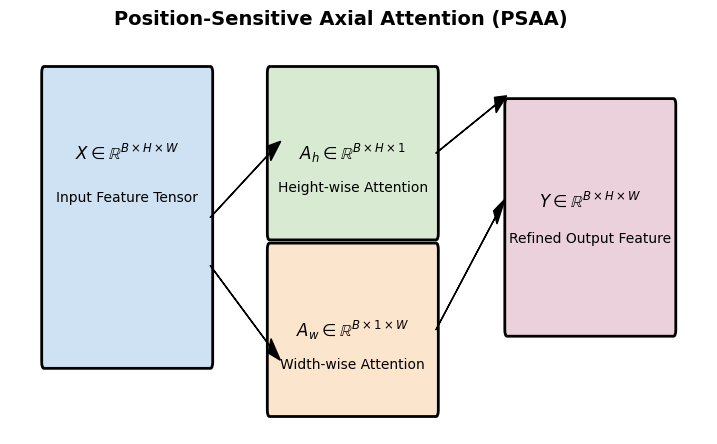

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure
fig, ax = plt.subplots(figsize=(9, 5))
ax.axis('off')

# ----- Input Tensor -----
ax.add_patch(patches.FancyBboxPatch((0.3, 0.35), 1.4, 0.9, boxstyle="round,pad=0.02", 
                                    edgecolor="black", facecolor="#cfe2f3", lw=2))
ax.text(1.0, 1.0, r"$X \in \mathbb{R}^{B \times H \times W}$", fontsize=12, ha='center', va='center', weight='bold')
ax.text(1.0, 0.85, "Input Feature Tensor", fontsize=10, ha='center')

# ----- Height-wise Attention -----
ax.add_patch(patches.FancyBboxPatch((2.2, 0.75), 1.4, 0.5, boxstyle="round,pad=0.02", 
                                    edgecolor="black", facecolor="#d9ead3", lw=2))
ax.text(2.9, 1.0, r"$A_h \in \mathbb{R}^{B \times H \times 1}$", fontsize=12, ha='center', va='center', weight='bold')
ax.text(2.9, 0.88, "Height-wise Attention", fontsize=10, ha='center')

# Arrow from X → A_h
ax.arrow(1.7, 0.8, 0.5, 0.2, head_width=0.05, head_length=0.1, fc='k', ec='k')

# ----- Width-wise Attention -----
ax.add_patch(patches.FancyBboxPatch((2.2, 0.2), 1.4, 0.5, boxstyle="round,pad=0.02", 
                                    edgecolor="black", facecolor="#fce5cd", lw=2))
ax.text(2.9, 0.45, r"$A_w \in \mathbb{R}^{B \times 1 \times W}$", fontsize=12, ha='center', va='center', weight='bold')
ax.text(2.9, 0.33, "Width-wise Attention", fontsize=10, ha='center')

# Arrow from X → A_w
ax.arrow(1.7, 0.65, 0.5, -0.25, head_width=0.05, head_length=0.1, fc='k', ec='k')

# ----- Output -----
ax.add_patch(patches.FancyBboxPatch((4.2, 0.45), 1.4, 0.7, boxstyle="round,pad=0.02", 
                                    edgecolor="black", facecolor="#ead1dc", lw=2))
ax.text(4.9, 0.85, r"$Y \in \mathbb{R}^{B \times H \times W}$", fontsize=12, ha='center', va='center', weight='bold')
ax.text(4.9, 0.72, "Refined Output Feature", fontsize=10, ha='center')

# Arrows from A_h and A_w to Y
ax.arrow(3.6, 1.0, 0.5, 0.15, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.arrow(3.6, 0.45, 0.5, 0.35, head_width=0.05, head_length=0.1, fc='k', ec='k')

# Title
plt.text(2.8, 1.4, "Position-Sensitive Axial Attention (PSAA)", fontsize=14, ha='center', weight='bold')

plt.show()


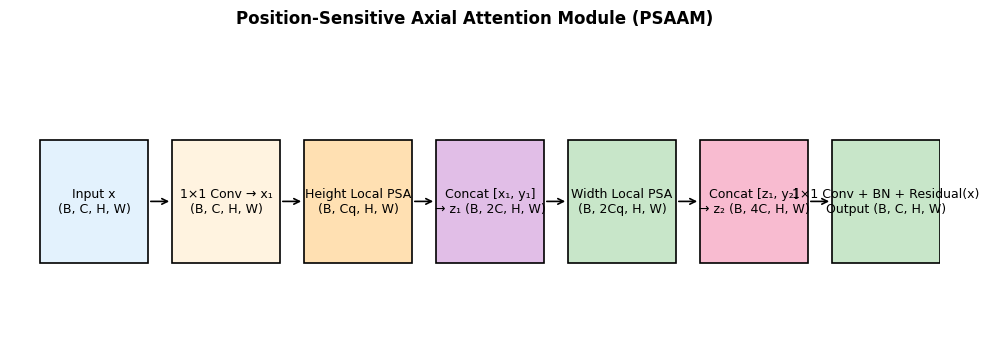

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("off")

# --- Helper functions ---
def box(x, y, text, color="#bbdefb"):
    """Draws a box with centered text"""
    rect = plt.Rectangle((x, y), 1.8, 0.8, fc=color, ec="black", lw=1.2)
    ax.add_patch(rect)
    ax.text(x + 0.9, y + 0.4, text, ha="center", va="center", fontsize=9, wrap=True)

def arrow(x1, y1, x2, y2):
    """Draws a right-pointing arrow between boxes"""
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", lw=1.2, color="black"))

# --- Block sequence ---
box(0, 0, "Input x\n(B, C, H, W)", "#e3f2fd")
arrow(1.8, 0.4, 2.2, 0.4)
box(2.2, 0, "1×1 Conv → x₁\n(B, C, H, W)", "#fff3e0")
arrow(4.0, 0.4, 4.4, 0.4)
box(4.4, 0, "Height Local PSA\n(B, Cq, H, W)", "#ffe0b2")
arrow(6.2, 0.4, 6.6, 0.4)
box(6.6, 0, "Concat [x₁, y₁]\n→ z₁ (B, 2C, H, W)", "#e1bee7")
arrow(8.4, 0.4, 8.8, 0.4)
box(8.8, 0, "Width Local PSA\n(B, 2Cq, H, W)", "#c8e6c9")
arrow(10.6, 0.4, 11.0, 0.4)
box(11.0, 0, "Concat [z₁, y₂]\n→ z₂ (B, 4C, H, W)", "#f8bbd0")
arrow(12.8, 0.4, 13.2, 0.4)
box(13.2, 0, "1×1 Conv + BN + Residual(x)\nOutput (B, C, H, W)", "#c8e6c9")

plt.xlim(-0.5, 15)
plt.ylim(-0.5, 1.5)
plt.title("Position-Sensitive Axial Attention Module (PSAAM)", fontsize=12, weight="bold")
plt.show()


In [38]:
class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x

In [39]:
class MSRecNet(nn.Module):
    def __init__(self):
        super(MSRecNet, self).__init__()
        self.conv3d_3_1 = nn.Sequential(nn.Conv3d(1, 64, (1, 3, 3), stride=1, padding=(0,1,1)), 
                        nn.BatchNorm3d(64),
                        nn.PReLU())
        self.conv3d_5_1 = nn.Sequential(nn.Conv3d(1, 64, (1, 5, 5), stride=1, padding=(0,2,2)), 
                        nn.BatchNorm3d(64),
                        nn.PReLU())
        self.conv3d_3_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 3, 3), stride=1, padding=(0,1,1)),
                        nn.BatchNorm3d(64),
                        nn.PReLU())
        self.conv3d_5_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 5, 5), stride=1, padding=(0,2,2)),
                        nn.BatchNorm3d(64),
                        nn.PReLU())            
        self.confusion = nn.Conv3d(128, 32, (1, 1, 1), padding=0, stride=1)
        self.pool3d = nn.MaxPool3d((1, 3, 3), stride=(1, 1, 1))

        self.conv3d2_3_1 = nn.Sequential(nn.Conv3d(32, 64, (1, 3, 3), stride=1, padding=(0,1,1)), 
                        nn.BatchNorm3d(64),
                        nn.PReLU())
        self.conv3d2_5_1 = nn.Sequential(nn.Conv3d(32, 64, (1, 5, 5), stride=1, padding=(0,2,2)), 
                        nn.BatchNorm3d(64),
                        nn.PReLU())
        self.conv3d2_3_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 3, 3), stride=1, padding=(0,1,1)),
                        nn.BatchNorm3d(64),
                        nn.PReLU())
        self.conv3d2_5_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 5, 5), stride=1, padding=(0,2,2)),
                        nn.BatchNorm3d(64),
                        nn.PReLU())            
        self.confusion2 = nn.Conv3d(128, 64, (1, 1, 1), padding=0, stride=1)
        
        self.deconv3d_1 = nn.Sequential(nn.Conv3d(64, 128, (1, 3, 3), stride=1, padding=(0,1,1)),
                          nn.BatchNorm3d(128),
                          nn.PReLU())
        self.deconv3d_2 = nn.Sequential(nn.Conv3d(128, 1, (1, 3, 3), stride=1, padding=(0,1,1)),
                          nn.BatchNorm3d(1))
        

    def forward(self, x):
      # Multi-scale hidden layer 1 with 5x5 and 3x3 filters and maxpooling after
        input1_1 = x
        output1_3_1 = self.conv3d_3_1(input1_1)
        output1_5_1 = self.conv3d_5_1(input1_1)
        input1_2 = torch.cat([output1_3_1, output1_5_1], 1)
        output1_3_2 = self.conv3d_3_2(input1_2)
        output1_5_2 = self.conv3d_5_2(input1_2)
        input2_1 = torch.cat([output1_3_2, output1_5_2], 1)  
        input2_1 = self.confusion(input2_1)
        input2_1 = self.pool3d(input2_1)

        # Multi-scale hidden layer 2 with 5x5 and 3x3 filters and maxpooling after
        output2_3_1 = self.conv3d2_3_1(input2_1)
        output2_5_1 = self.conv3d2_3_1(input2_1)
        input2_2 = torch.cat([output2_3_1, output2_5_1], 1)
        output2_3_2 = self.conv3d2_3_2(input2_2)
        output2_5_2 = self.conv3d2_3_2(input2_2)
        input3_1 = torch.cat([output2_3_2, output2_5_2], 1)
        input3_1 = self.confusion2(input3_1)
        input3_1 = self.pool3d(input3_1) 

        x=nn.functional.interpolate(input3_1, (200,3,3), mode= 'trilinear')
        x = self.deconv3d_1(x)
        x=nn.functional.interpolate(x, (200,5,5), mode= 'trilinear')
        x = self.deconv3d_2(x)
        
        return x.squeeze(1)

In [40]:
class CoordinateAttentionWrapper(nn.Module):
    def __init__(self):
        super(CoordinateAttentionWrapper, self).__init__()
        self.ca = None  # Placeholder, will be initialized dynamically

    def forward(self, x):
        if self.ca is None:
            in_channels = x.size(1)  # Dynamically infer channels
            self.ca = PSAAM(in_channels=in_channels).to(x.device)
        return self.ca(x)

In [41]:
class DANet(nn.Module):
    def __init__(self):
        super(DANet, self).__init__()
        self.coord_att = CoordinateAttentionWrapper()
        self.MSRecNet = MSRecNet()

    def forward(self, x):
        J = self.coord_att(x)  # [B, C, H, W]
        J = J.unsqueeze(1)     # [B, 1, C, H, W]
        ret = self.MSRecNet(J)
        return ret

    
danet_model = DANet().to(device)

In [42]:

from torchsummary import summary
summary(danet_model,input_size=(200,5,5))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
CoordinateAttentionWrapper-1            [-1, 200, 5, 5]               0
            Conv3d-2        [-1, 64, 200, 5, 5]             640
       BatchNorm3d-3        [-1, 64, 200, 5, 5]             128
             PReLU-4        [-1, 64, 200, 5, 5]               1
            Conv3d-5        [-1, 64, 200, 5, 5]           1,664
       BatchNorm3d-6        [-1, 64, 200, 5, 5]             128
             PReLU-7        [-1, 64, 200, 5, 5]               1
            Conv3d-8        [-1, 64, 200, 5, 5]          73,792
       BatchNorm3d-9        [-1, 64, 200, 5, 5]             128
            PReLU-10        [-1, 64, 200, 5, 5]               1
           Conv3d-11        [-1, 64, 200, 5, 5]         204,864
      BatchNorm3d-12        [-1, 64, 200, 5, 5]             128
            PReLU-13        [-1, 64, 200, 5, 5]               1
           Conv3d-14        [-1

In [15]:
#!pip install git+https://github.com/IssamLaradji/sps.git

In [23]:
!pip install scikit-image

     ---------------------------------------- 12.8/12.8 MB 7.8 MB/s eta 0:00:00
     -------------------------------------- 315.8/315.8 kB 6.5 MB/s eta 0:00:00
     -------------------------------------- 226.5/226.5 kB 4.6 MB/s eta 0:00:00


In [16]:
"""import sps
optimizer = sps.Sps(danet_model.parameters())"""

'import sps\noptimizer = sps.Sps(danet_model.parameters())'

In [43]:
#model = BSNET_Conv().to(device) 

optimizer = optim.SGD(danet_model.parameters(), lr=0.01, momentum=0.9)

In [44]:
top = 25

In [45]:


import skimage
import kornia

from kornia.losses import ssim_loss, psnr_loss

# Kornia Loss Functions
def ssim(data, output):
    return ssim_loss(data, output, window_size=5, reduction='mean')

def psnr_torch(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target, reduction='mean')
    if mse.item() == 0:
        return torch.tensor(float('inf'))  # perfect match
    psnr = 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(mse)
    return psnr

global bsnlist
#ssim = kornia.losses.SSIM(5, reduction='none')
#psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    danet_model.train()
    ENTROPY = torch.zeros(200)
    
    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = danet_model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,200):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = 1.0 - torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr_torch(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top), [int(x) for x in bsnlist])
    
    


for epoch in range(0, 100):
    train(epoch)
    

Train Epoch: 0 [0/10249 (0%)]	Loss: 0.834281
SSIM: 0.5016785860061646
PSNR: -1.274591088294983


C:\Users\anish\AppData\Local\Temp\ipykernel_20496\4134152975.py:58: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ENTROPY = np.array(ENTROPY)


Top 25 bands with Entropy -> [174, 189, 27, 153, 119, 107, 123, 140, 15, 75, 49, 98, 125, 76, 187, 39, 135, 161, 128, 131, 111, 139, 198, 120, 79]
Train Epoch: 1 [0/10249 (0%)]	Loss: 0.183360
SSIM: 0.6300791501998901
PSNR: 12.240880966186523
Top 25 bands with Entropy -> [157, 140, 178, 139, 187, 101, 92, 141, 39, 33, 123, 110, 122, 113, 144, 190, 135, 181, 69, 94, 164, 168, 153, 148, 12]
Train Epoch: 2 [0/10249 (0%)]	Loss: 0.165740
SSIM: 0.7089848518371582
PSNR: 13.078508377075195
Top 25 bands with Entropy -> [157, 173, 133, 153, 165, 166, 85, 101, 89, 87, 32, 73, 144, 131, 92, 69, 124, 114, 132, 128, 24, 72, 29, 23, 123]
Train Epoch: 3 [0/10249 (0%)]	Loss: 0.138344
SSIM: 0.7683396339416504
PSNR: 14.457036972045898
Top 25 bands with Entropy -> [56, 25, 26, 79, 73, 109, 120, 127, 122, 115, 112, 91, 69, 78, 64, 84, 154, 3, 21, 53, 38, 19, 51, 40, 131]
Train Epoch: 4 [0/10249 (0%)]	Loss: 0.116566
SSIM: 0.8104110956192017
PSNR: 15.734722137451172
Top 25 bands with Entropy -> [93, 91, 74, 7

In [46]:
x,xx,xxx = psnr_list,ssim_list,l1_list
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

100
100
100


In [47]:
def safe_to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()  # ✅ Move tensor to CPU & convert
    elif isinstance(data, list):  
        return np.array([safe_to_numpy(d) for d in data])  # ✅ Convert each item in list
    return np.asarray(data)  # ✅ Convert NumPy arrays safely

# Save safely
np.save('psnr_PSAA_IP.npy', safe_to_numpy(x))
np.save('ssim_PSAA_IP.npy', safe_to_numpy(xx))
np.save('l1_PSAA_IP.npy', safe_to_numpy(xxx))


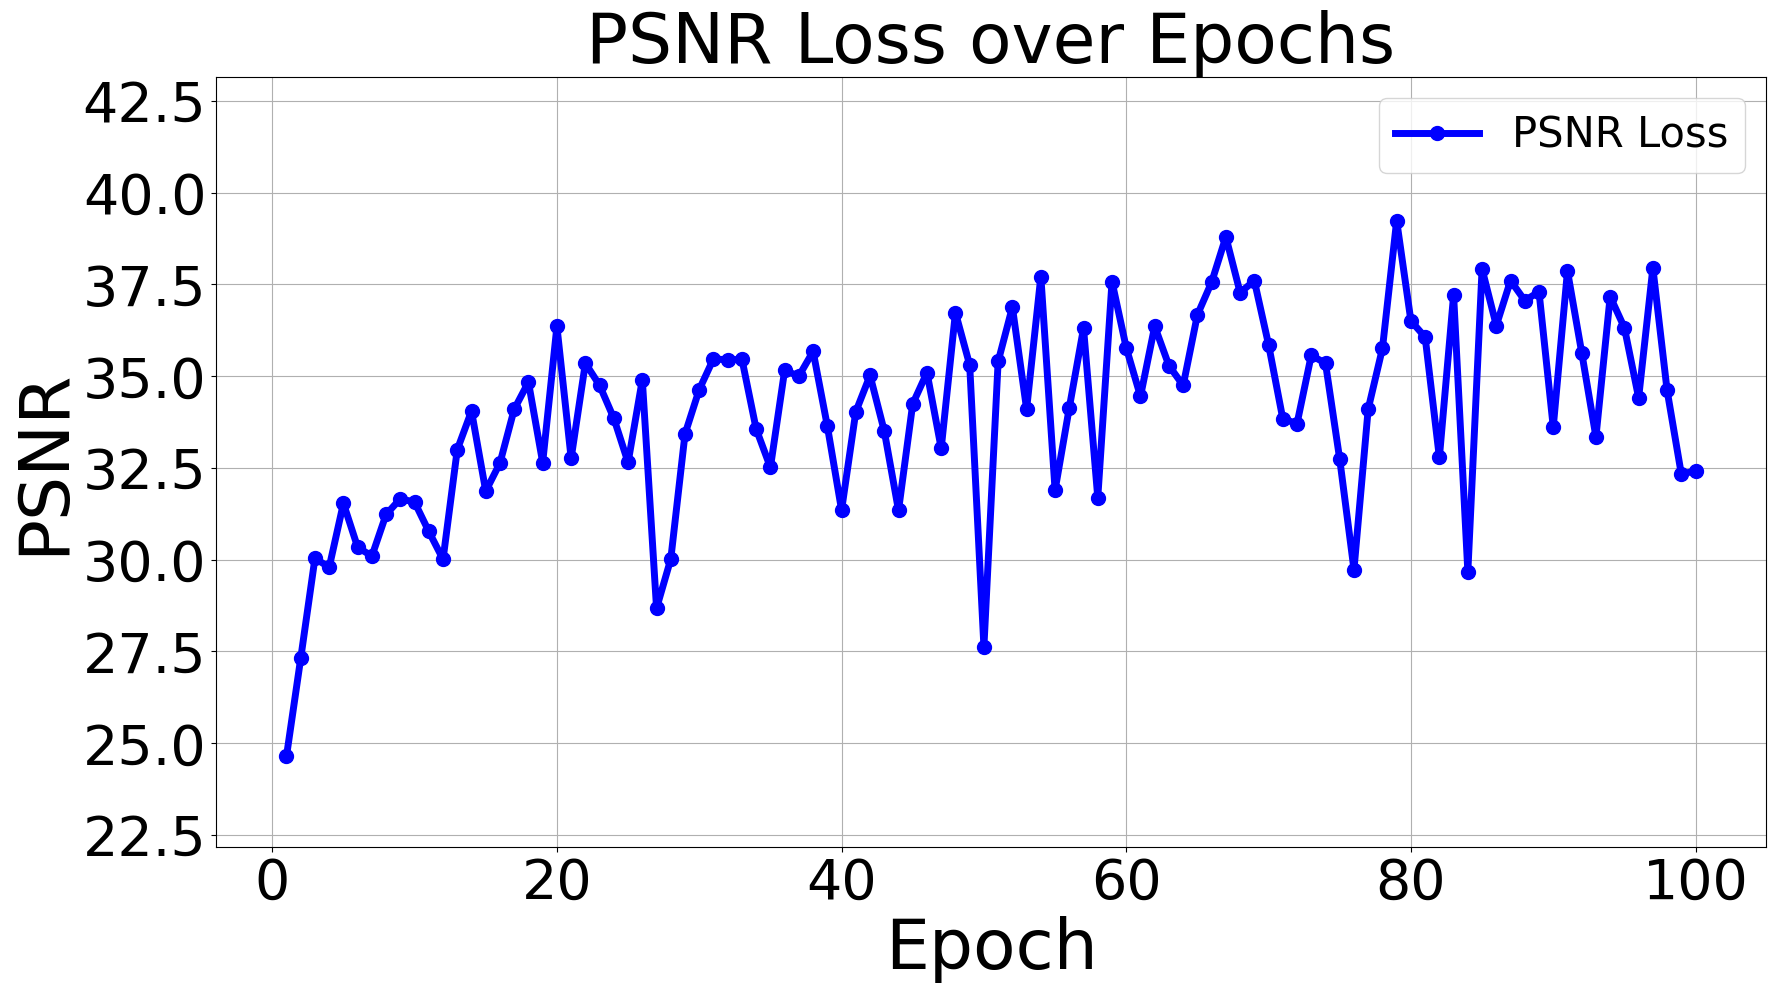

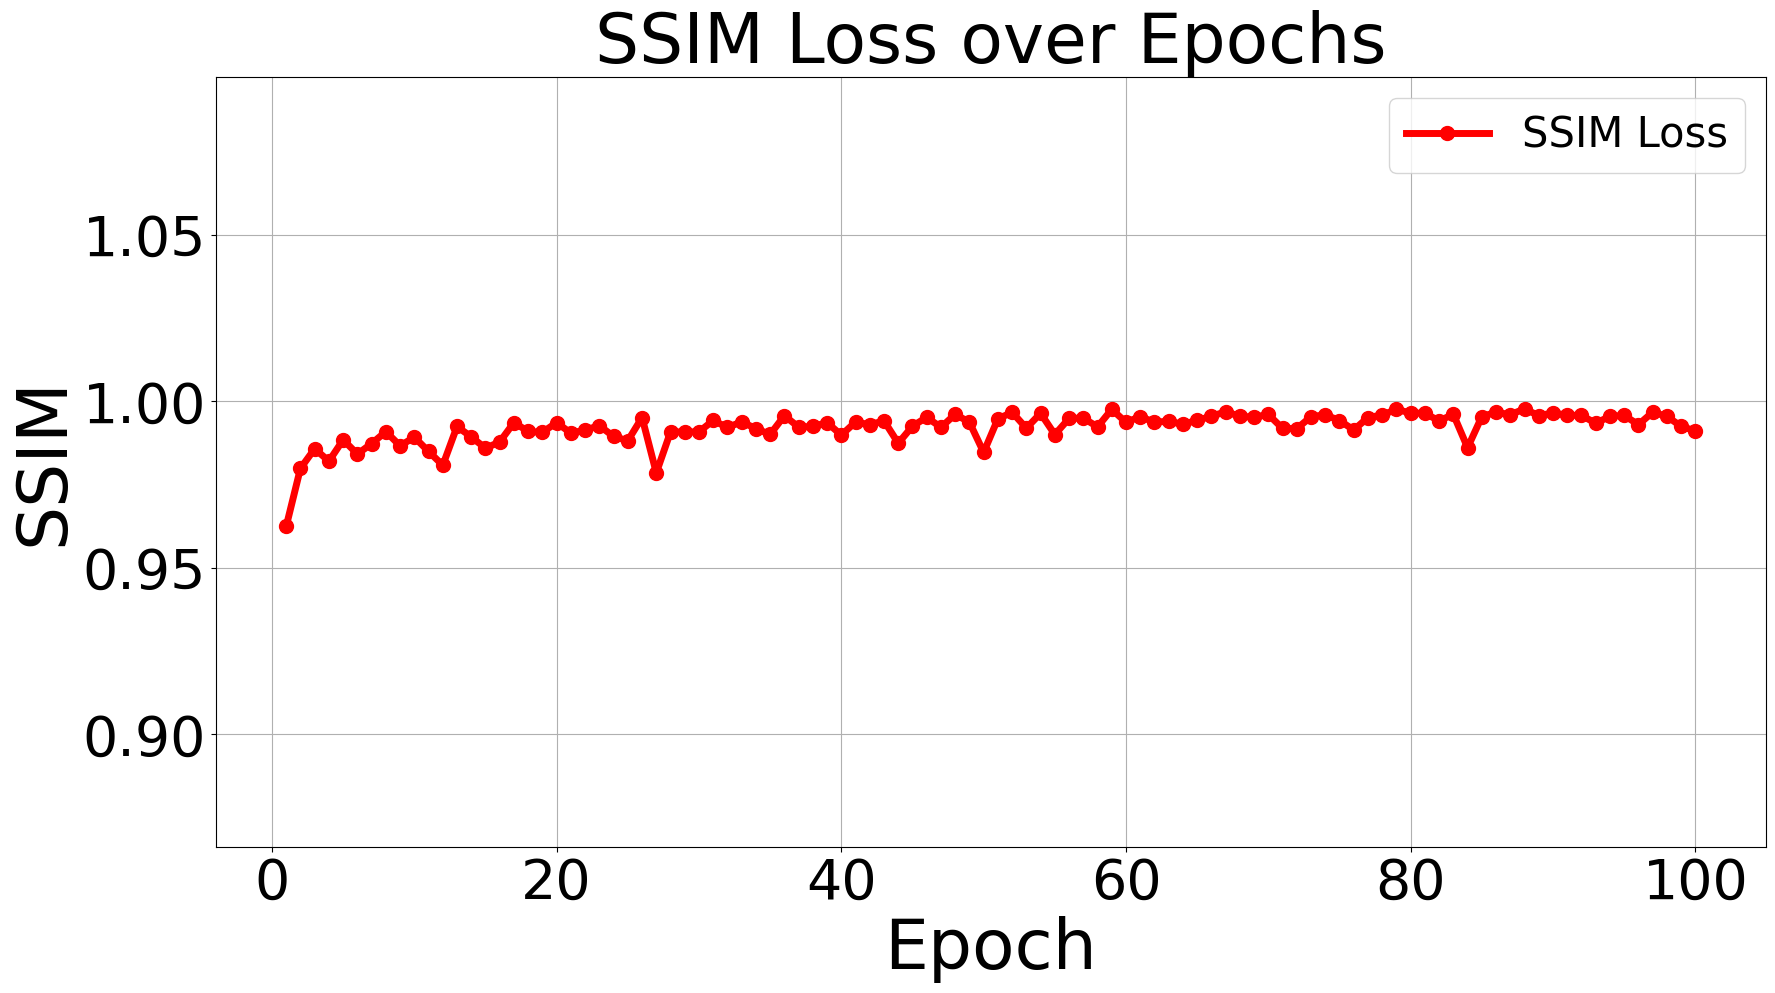

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def safe_to_numpy(data):
    """Convert CUDA tensors & lists to NumPy arrays safely."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()  # ✅ Move tensor to CPU & convert
    elif isinstance(data, list):
        return np.array([safe_to_numpy(d) for d in data])  # ✅ Convert each tensor inside list
    return np.asarray(data)  # ✅ Convert lists or NumPy arrays safely

# ✅ Convert PSNR & SSIM lists properly
psnr_numpy = safe_to_numpy(psnr_list)
ssim_numpy = safe_to_numpy(ssim_list)

# ✅ Ensure both arrays are 1D
if psnr_numpy.ndim > 1:
    psnr_numpy = psnr_numpy.squeeze()

if ssim_numpy.ndim > 1:
    ssim_numpy = ssim_numpy.squeeze()

epochs = range(1, len(psnr_numpy) + 1)  # Epoch indices

# 🔹 **Plot PSNR Loss**
plt.figure(figsize=(20, 10))
plt.plot(epochs, psnr_numpy, linewidth=5.0, marker='o', markersize=10, label="PSNR Loss", color="blue")
plt.xlabel('Epoch', fontsize=50)
plt.ylabel('PSNR', fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.ylim(min(psnr_numpy) * 0.9, max(psnr_numpy) * 1.1)  # Dynamic limits
plt.legend(fontsize=30)
plt.title("PSNR Loss over Epochs", fontsize=50)
plt.grid(True)
plt.savefig('PSAA-PSNR-Loss-IP_100_Epoch.pdf')
plt.show()

# 🔹 **Plot SSIM Loss**
plt.figure(figsize=(20, 10))
plt.plot(epochs, ssim_numpy, linewidth=5.0, marker='o', markersize=10, label="SSIM Loss", color="red")
plt.xlabel('Epoch', fontsize=50)
plt.ylabel('SSIM', fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.ylim(min(ssim_numpy) * 0.9, max(ssim_numpy) * 1.1)  # Dynamic limits
plt.legend(fontsize=30)
plt.title("SSIM Loss over Epochs", fontsize=50)
plt.grid(True)
plt.savefig('SP-SSIM-Loss-IP_100_Epoch.pdf')
plt.show()


Length of SSIM list: 100
SSIM Values (First 10): [0.5009501  0.8248435  0.9130865  0.9581871  0.9506069  0.97849864
 0.9830665  0.9847262  0.98226565 0.9898226 ]


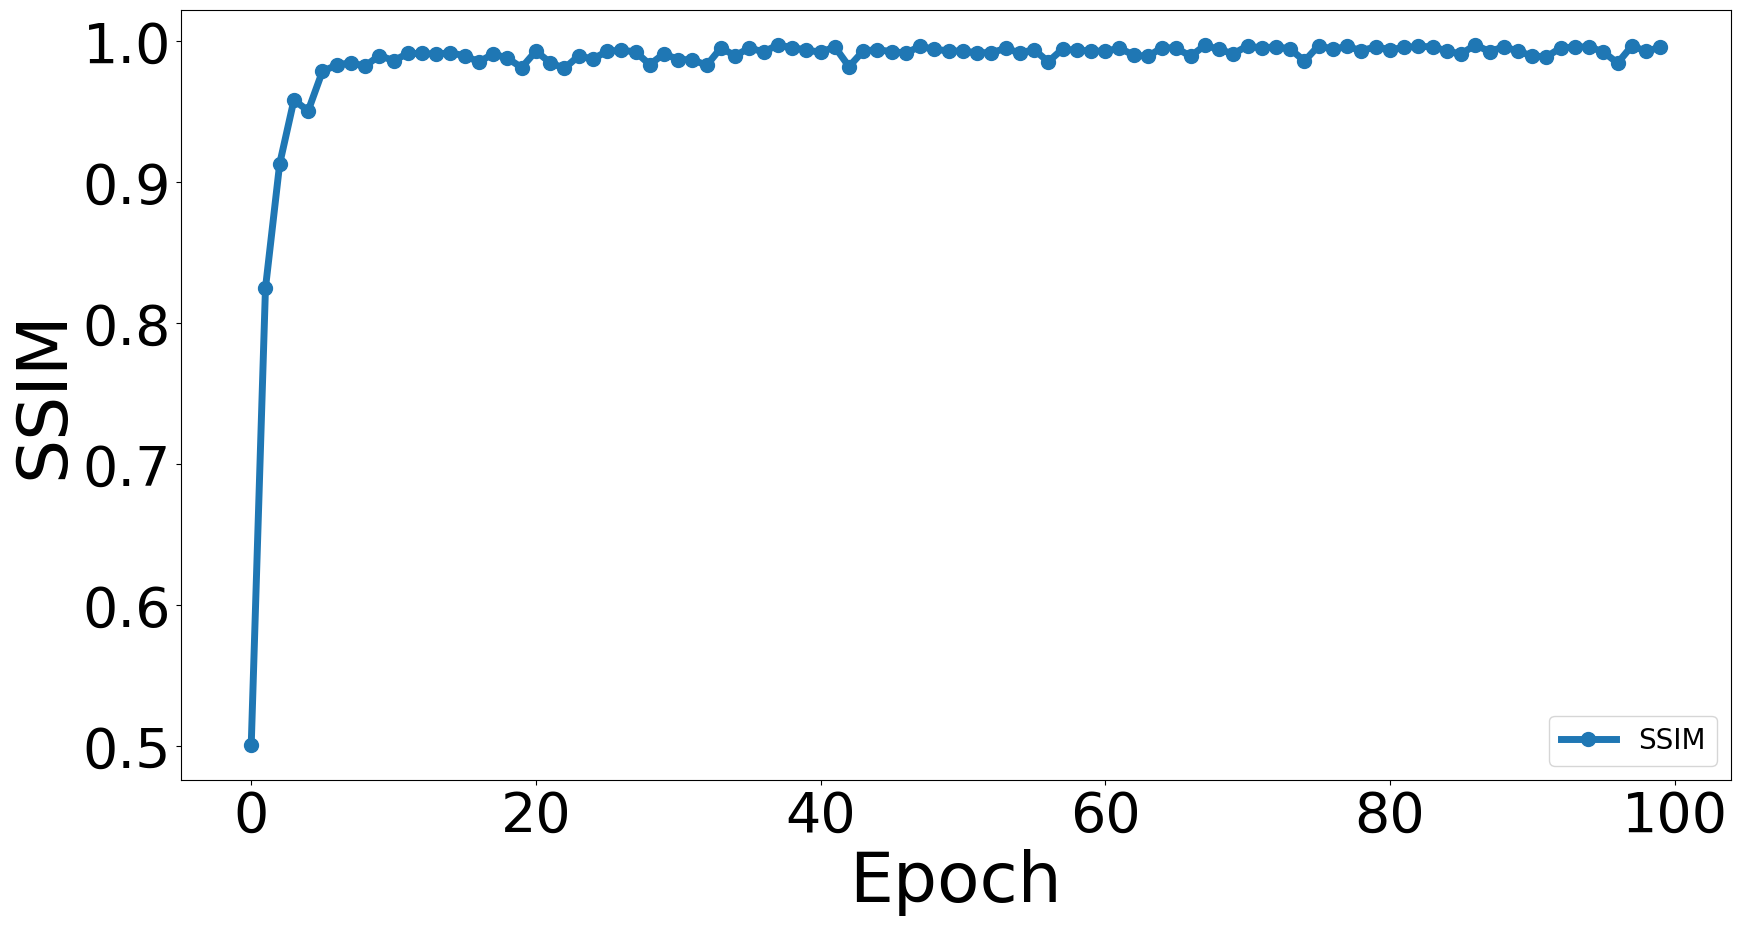

In [20]:
xx = np.array([
    val.cpu().detach().numpy() if isinstance(val, torch.Tensor) else val
    for val in ssim_list
])

# Debugging: Check lengths and values
print("Length of SSIM list:", len(xx))
print("SSIM Values (First 10):", xx[:10])  # Print first 10 values for verification

# Remove extra dimensions if any
xx = np.squeeze(xx)

# Handle NaN/Inf values
xx = np.nan_to_num(xx, nan=0.0, posinf=1.0, neginf=0.0)

# Define X-axis (epochs)
epochs = np.arange(len(xx))

# Ensure there is enough data to plot
if len(epochs) > 1:
    plt.figure(figsize=(20, 10)) 
    plt.xlabel('Epoch', fontsize=50)
    plt.ylabel('SSIM', fontsize=50)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # Plot the SSIM values
    plt.plot(epochs, xx, linewidth=5.0, marker='o', markersize=10, label="SSIM")
    plt.legend(fontsize=20)
    
    # Save the figure
    plt.savefig('SSIM-CA-IP_100_Epoch.pdf')
    plt.show()
else:
    print("Not enough data points to plot a graph.")


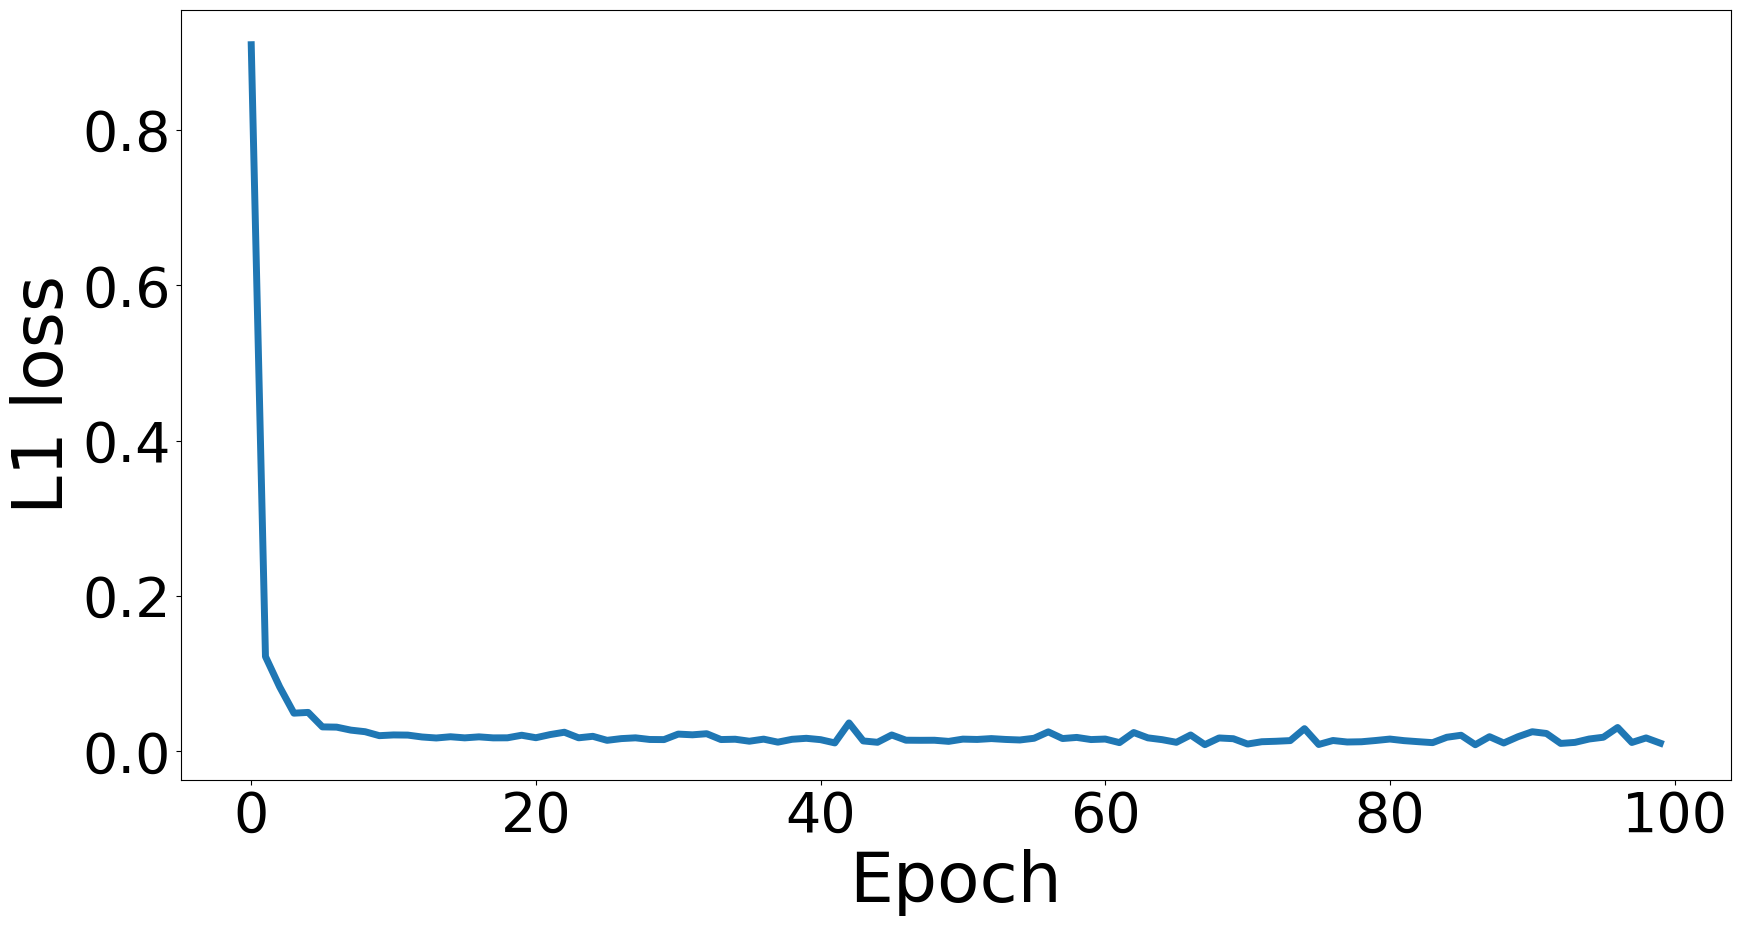

In [21]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-CA-IP_100_Epoch.pdf')
plt.show()



## Below is SSIM based optimization

In [22]:
#!git clone https://github.com/Po-Hsun-Su/pytorch-ssim.git

In [23]:
#!ls /content/

In [24]:
#!cp -r /content/pytorch-ssim/pytorch_ssim/ /content/

In [25]:
"""import skimage
import pytorch_ssim
global bsnlist
ssim_loss = pytorch_ssim.SSIM()
import kornia
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
channel_weight_list = []
def train(epoch):    
    danet_model.train()
    ENTROPY = torch.zeros(200)
    
    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = danet_model(data)
        ssim_out = -ssim_loss(data, output)
        ssim_value = - ssim_out.item()
        ssim_out.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,200):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % 600 == 0:

                   
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), ssim_value))
            print("PSNR: {}".format(psnr(data,output)))
        
    #ENTROPY/=160
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 100):
    train(epoch)
    """

'import skimage\nimport pytorch_ssim\nglobal bsnlist\nssim_loss = pytorch_ssim.SSIM()\nimport kornia\npsnr = kornia.losses.PSNRLoss(2500)\nfrom skimage import measure\nchannel_weight_list = []\ndef train(epoch):    \n    danet_model.train()\n    ENTROPY = torch.zeros(200)\n    \n    for batch_idx, (data, __) in enumerate(train_loader):\n        data = data.to(device)\n        optimizer.zero_grad()\n        output = danet_model(data)\n        ssim_out = -ssim_loss(data, output)\n        ssim_value = - ssim_out.item()\n        ssim_out.backward()\n        optimizer.step()\n        D = output.detach().cpu().numpy()\n        for i in range(0,200):\n\n          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])\n        \n        if batch_idx % 600 == 0:\n\n                   \n            print(\'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\'.format(\n                epoch, batch_idx * len(data), len(train_loader.dataset),\n                100. * batch_idx / len(train_loader), ssim

# Band MSD and some plots

In [11]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20  
  info_div = 0  
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [12]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [13]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [14]:
tabsrecnet = [119, 91, 75, 78, 122, 163, 56, 52, 83, 45, 37, 34, 137, 69, 4, 133, 171, 61, 111, 60, 57, 7, 148, 53, 192]
dabsrecnet = [154, 12, 112, 88, 133, 127, 158, 13, 113, 51, 152, 125, 30, 58, 126, 168, 95, 32, 75, 31, 82, 22, 142, 86, 123]
bsnetconv = [46,33,140,161,80,35,178,44,126,36,138,71,180,66,192,16,53,152,185,119,24,28,26,156,83]
pca = [167,74,168,0,147,165,161,162,152,19,160,119,164,159,157,163,158,156,20,154,118,148,153,149,155]
spabs = [7, 96, 52, 171, 53, 3, 76, 75, 74, 95, 77, 73, 78, 54, 81,94,88,91,71,72,79,80,55,92,56] 
snmf = [23,197,198,94,76,2,87,105,143,145,11,84,132,108,28,104,144,34,44,74,71,96,75,171,162]


#dabsold = [126, 84, 154, 124, 129, 127, 87, 88, 57, 65, 153, 80, 59, 156, 76, 91, 163, 125, 130, 123, 67, 111, 141, 53, 149]


In [15]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    
MSA(tabsrecnet)
MSA(dabsrecnet)
MSA(bsnetconv)
MSA(pca)
MSA(spabs)
MSA(snmf)





[ 6.268808798770571 , 4.706698556313699 , 4.18362418650169 , 3.924651129812383 , 3.766995797608583 , 3.6632677053895333 , 3.5880631859876986 , 3.532348981399918 , 3.4889945106865285 , 3.4543471238574304 , 3.4258352856380228 , 3.402257816625762 , 3.3821954486871477 , 3.3649900820618996 , 3.350135626690265 , 3.3370957617063164 , 3.325545806168151 , 3.315396186061623 , 3.3062241893942392 , 3.2979886851444755 , 3.2905587000606618 , 3.2837983470098573 , 3.277607401664165 ]
[ 6.2730408413107845 , 4.7085535224795105 , 4.183174181057516 , 3.923776833409783 , 3.7677873994952407 , 3.6627284726285714 , 3.5887420429787715 , 3.532705387261601 , 3.48914216633686 , 3.454288031606742 , 3.425823814673791 , 3.402297236247881 , 3.382037557695645 , 3.3651140364717036 , 3.3500917338784926 , 3.337100543545866 , 3.3255588728581333 , 3.315321418652446 , 3.306207595591922 , 3.298045030231039 , 3.2905238931208833 , 3.283715493694796 , 3.277591954970748 ]
[ 6.278871895393927 , 4.704068155502441 , 4.1847475585192

In [16]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSD(tabsrecnet)
MSD(dabsrecnet)
MSD(bsnetconv)
MSD(pca)
MSD(spabs)
MSD(snmf)
#MSD(issc)




[ 30.25788737499909 , 25.510285153658458 , 18.80749744527998 , 17.028227961816835 , 21.156293783955693 , 23.76029447401483 , 21.55907085567718 , 22.760535147107316 , 21.270278921385255 , 19.459361242660844 , 18.78299958350172 , 19.14474090593971 , 19.312921666379296 , 23.04770221226874 , 22.209178411293156 , 23.261814736139776 , 24.431842770157637 , 24.06725515662183 , 25.589971686983585 , 25.203067955402588 , 26.689792509814918 , 27.473150897034387 , 26.943740992391465 ]
[ 33.12881252113703 , 27.699269748852547 , 31.189050523240567 , 25.407158521806743 , 21.23842365661258 , 21.4600299169822 , 20.86248085946583 , 20.17228040657472 , 20.53299041484558 , 21.1335634998955 , 19.59117061832842 , 20.946230004039375 , 22.843494279707382 , 21.596483466175062 , 21.633130554147392 , 22.832050045391185 , 23.112561570936894 , 23.938250673675114 , 24.27697303727743 , 24.67049003424132 , 24.818116958133697 , 24.450204537801287 , 25.019421764795172 ]
[ 24.926582298710684 , 21.330938461786815 , 23.040

In [17]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    
EntropySum(tabsrecnet)
EntropySum(dabsrecnet)
EntropySum(bsnetconv)
EntropySum(pca)
EntropySum(spabs)
EntropySum(snmf)
#EntropySum(issc)



[ 21.438917807483392 , 32.148204597896296 , 41.703146580445 , 52.45749959257041 , 62.08800566874026 , 73.68161384942087 , 85.69313300486772 , 96.21572197010697 , 108.43890018689969 , 120.77451784314869 , 132.67064669148183 , 142.92674713554882 , 154.77094324450283 , 165.49152741153 , 176.02999008006475 , 185.27429387994587 , 196.766169619557 , 206.9491678642943 , 218.0662938314076 , 228.4956060840129 , 239.87296436876025 , 249.24094005433648 , 261.24441370090375 ]
[ 20.905239036720836 , 31.584922112621634 , 42.308339118118724 , 52.84680178665347 , 63.61131903624624 , 73.16650543923579 , 85.1037122426576 , 96.00913840419082 , 108.39352835503783 , 117.33560179453637 , 128.21321287591948 , 140.40154574243303 , 150.97442231970794 , 161.7691765679261 , 171.11831485205943 , 181.4512615185745 , 193.45796226810216 , 204.16724905851507 , 215.64325461192936 , 226.1965275761768 , 238.3111692727675 , 246.31364854400385 , 256.90988195823275 ]
[ 24.520691123780665 , 34.065954122992856 , 43.699039884

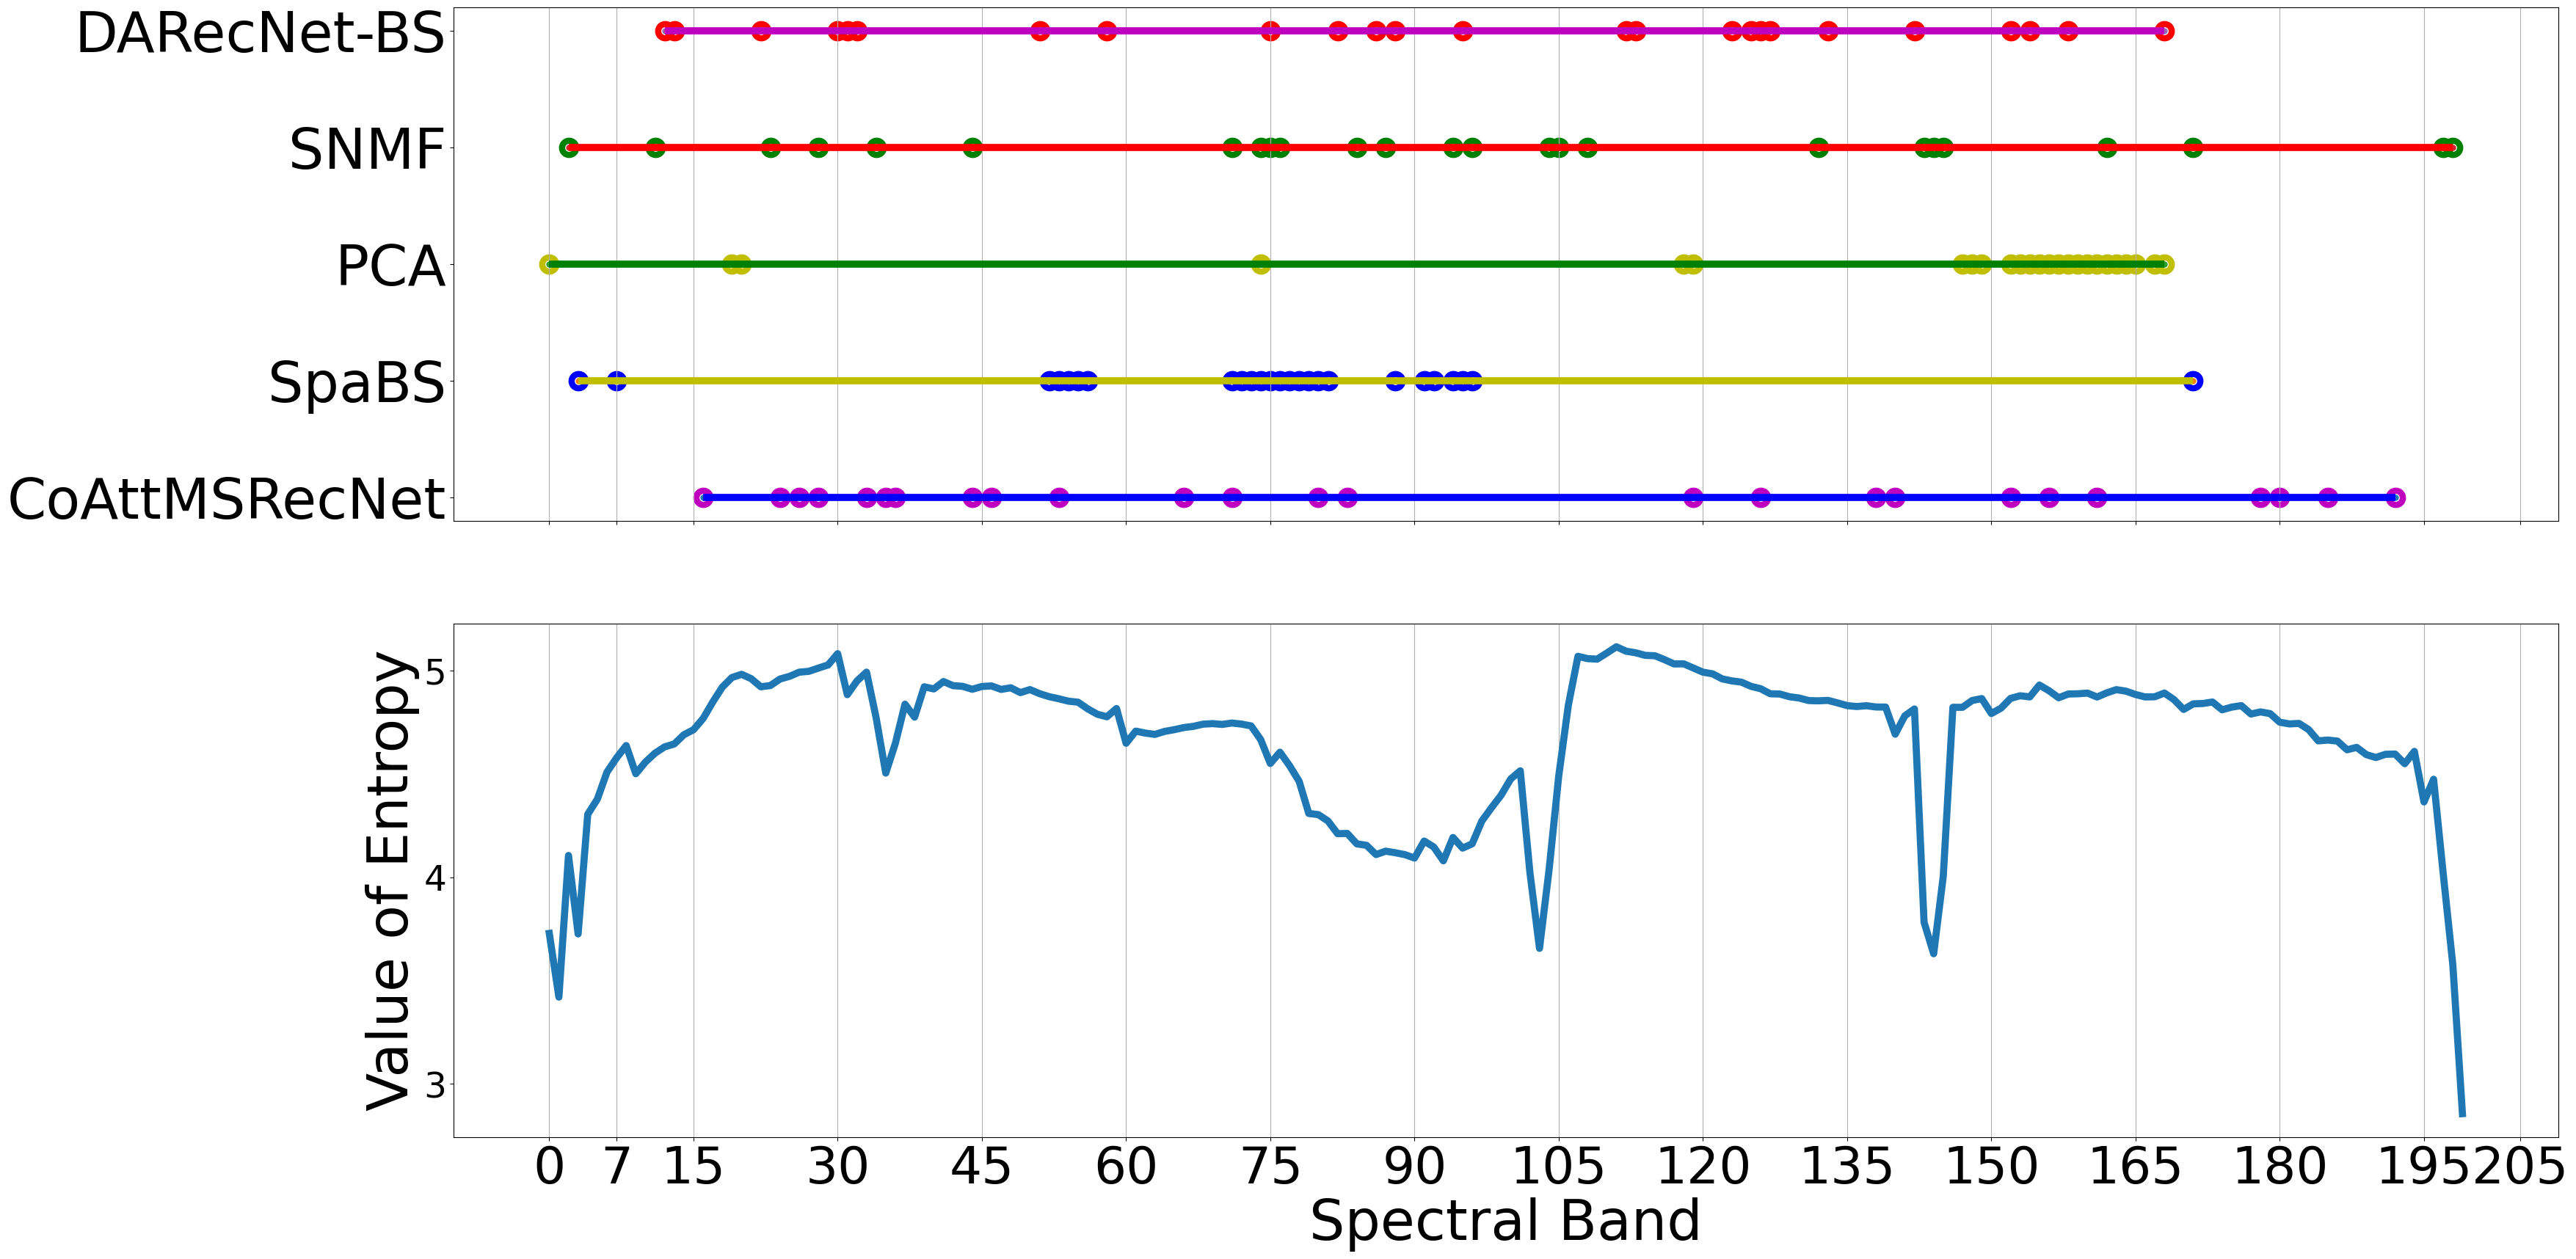

In [18]:
import os
# if not (os.path.isfile('/content/IN.csv')):
#   !wget https://raw.githubusercontent.com/ucalyptus/Double-Branch-Dual-Attention-Mechanism-Network/master/IN.csv
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("D:/hsi/model/Triplet_Attention/Plot2/CO_IP_100.csv")
import matplotlib.pyplot as plt
X, _ = loadData()
n_row,n_column,n_band= X.shape
N = n_row * n_column
hist = []
Entropy  = []
for i in range(n_band):
  hist_, _ = np.histogram(X[:, :, i], 256)
  hist.append(hist_ / N)
  band_i = hist[i].reshape(-1)/np.sum(hist[i])
  entr_i = entropy(band_i)
  Entropy.append(entr_i)
 
for i in range(0,len(df['Selected Bands'])):
  df['Selected Bands'][i] = re.findall('[0-9]+', df['Selected Bands'][i])
  df['Selected Bands'][i] = [int(k) for k in df['Selected Bands'][i]]
meth = ["CoAttMSRecNet","SpaBS","PCA","SNMF","DARecNet-BS"]
cols = ['b','y','g','r','m']
fig1,(ax1,ax2) = plt.subplots(2,sharex='col',figsize=(37,20))
ax1.grid(True)
ax1.yaxis.grid(False)
ax1.set_xticks([0,7,15,30,45,60,75,90,105,120,135,150,165,180,195,205])
ax1.yaxis.set_tick_params(labelsize=55)
plt.ylabel(meth)
scatar = []
for i in range(0,len(meth)):
  ax1.hlines(y = meth[i],xmin=min(df['Selected Bands'][i]),xmax=max(df['Selected Bands'][i]),colors=cols[i],linewidth=7)
  SCATTER = ax1.scatter(x=df['Selected Bands'][i],y = [i]*25,edgecolors=cols[i-1],linewidths=14)
  scatar.append(SCATTER)
ax2.grid(True)
ax2.yaxis.grid(False)
ax2.set_yticks([1,2,3,4,5])
ax2.set_ylabel("Value of Entropy",fontsize=55)
ax2.set_xlabel("Spectral Band",fontsize=55)
ax2.xaxis.set_tick_params(labelsize=50)
ax2.yaxis.set_tick_params(labelsize=35)
ax2.plot(Entropy,linewidth=7)
plt.savefig('Entropy_CA_IP_100_Epoch.pdf')

